In [1]:
#import libraries
import os
import pandas as pd
import string
from sklearn.utils import shuffle
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud     #Install wordcloud using conda using 'conda install -c conda-forge wordcloud'
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
import itertools
from datetime import datetime
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
In C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matp

In [2]:
#Read data

folder = os.getcwd()
Fake_data_file_name = 'Fake.csv'
True_data_file_name = 'True.csv'

if os.path.isfile(Fake_data_file_name):
    fake = pd.read_csv(Fake_data_file_name)
else:
    print ("Error: Fake.csv does not exist in ", folder)
    
if os.path.isfile(True_data_file_name):
    true = pd.read_csv(True_data_file_name)
else:
    print ("Error: True.csv does not exist in ", folder)


In [3]:
# Flag added to differentiate fake and true data. This is the target variable
fake['target'] = 'FAKE'
true['target'] = 'TRUE'

In [4]:
data = pd.concat([fake, true]).reset_index(drop = True)

# Shuffle data to prevent bias
data = shuffle(data)
data = data.reset_index(drop = True)

## Data Cleaning

In [5]:
# Data cleaning

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(punctuation_removal)
data['subject'] = data['subject'].replace('politicsNews', 'politics')
data['subject'] = data['subject'].replace('_', '-')

stop = stopwords.words('english')
# remove stopwords
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [6]:
data['date'] = data['date'].str.replace('Jan ', 'January ')
data['date'] = data['date'].str.replace('Feb ', 'February ')
data['date'] = data['date'].str.replace('Mar ', 'March ')
data['date'] = data['date'].str.replace('Apr ', 'April ')
data['date'] = data['date'].str.replace('Jun ', 'June ')
data['date'] = data['date'].str.replace('Jul ', 'July ')
data['date'] = data['date'].str.replace('Aug ', 'August ')
data['date'] = data['date'].str.replace('Sep ', 'September ')
data['date'] = data['date'].str.replace('Oct ', 'October ')
data['date'] = data['date'].str.replace('Nov ', 'November ')
data['date'] = data['date'].str.replace('Dec ', 'December ')
data.date = data.date.str.strip()
data = data[data.date.str.len() <= 18]  #drop values where the data is not correct in Date field
data.date = data.date.apply(lambda x: datetime.strptime(x, "%B %d, %Y") if (len(x) > 9 & len(x) < 18) else datetime.strptime(x, "%d-%b-%y"))

data['year'] = data['date'].dt.to_period('Y')
data['month'] = data['date'].dt.to_period('M')
data['month'] = data['month'].astype(str)

## Data Exploration

subject
Government News     1568
Middle-east          778
News                9050
US_News              783
left-news           4456
politics           18108
worldnews          10145
Name: text, dtype: int64


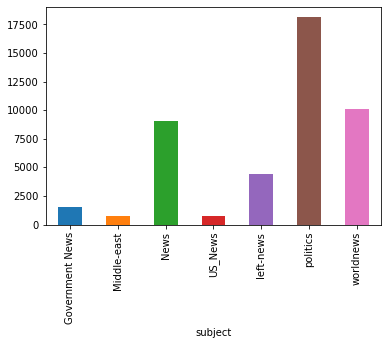

In [7]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

<Figure size 432x288 with 0 Axes>

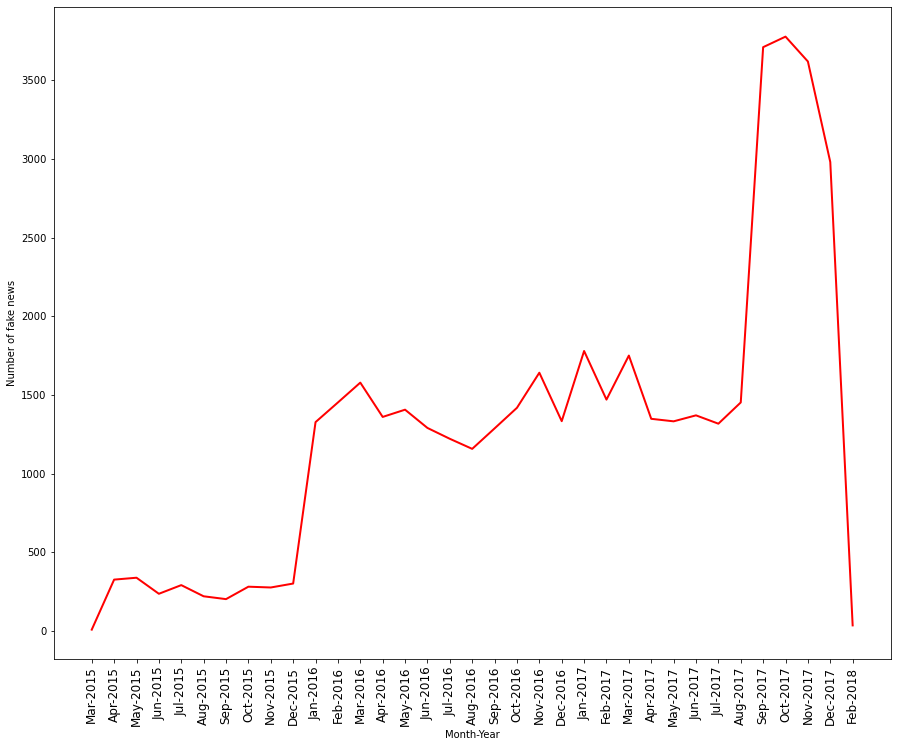

In [8]:

monthly_data = data.groupby(['month'])['text'].count()
monthly_data = monthly_data.reset_index(level=0)
monthly_data.month = pd.to_datetime(monthly_data.month)
monthly_data.month = monthly_data.month.apply(lambda x: x.strftime("%b-%Y"))
plt.suptitle('Dynamics of fake news')
plt.figure(figsize=(15,12))
plt.xticks(rotation=90)
plt.ylabel('Number of fake news')
plt.xlabel('Month-Year')
plt.tick_params(axis='x', which='major', labelsize=12)
plt.plot(monthly_data.month, monthly_data.text, linewidth=2, color='red')

target
FAKE    23471
TRUE    21417
Name: text, dtype: int64


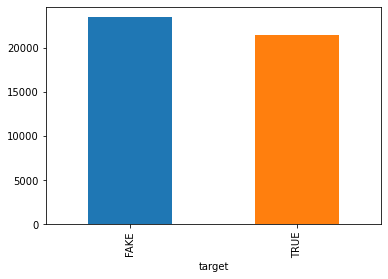

In [9]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

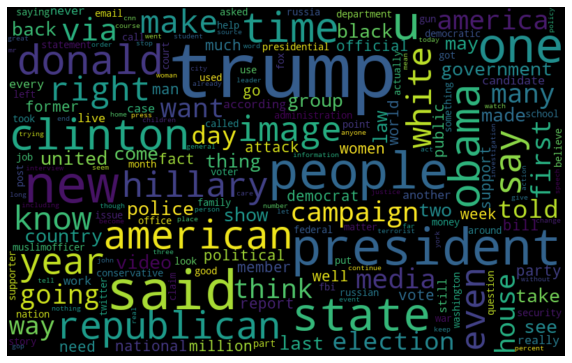

In [10]:
# Wordcloud for Fake News
fake_data = data[data["target"] == "FAKE"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud_fake = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

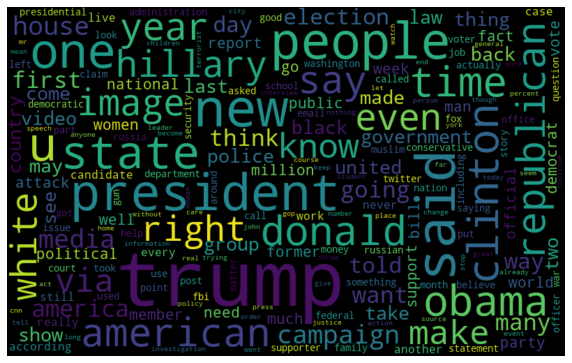

In [11]:
# Wordcloud for True News
real_data = data[data['target'] == 'TRUE']
all_words = ' '.join([text for text in fake_data.text])

wordcloud_true = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis("off")
plt.show()

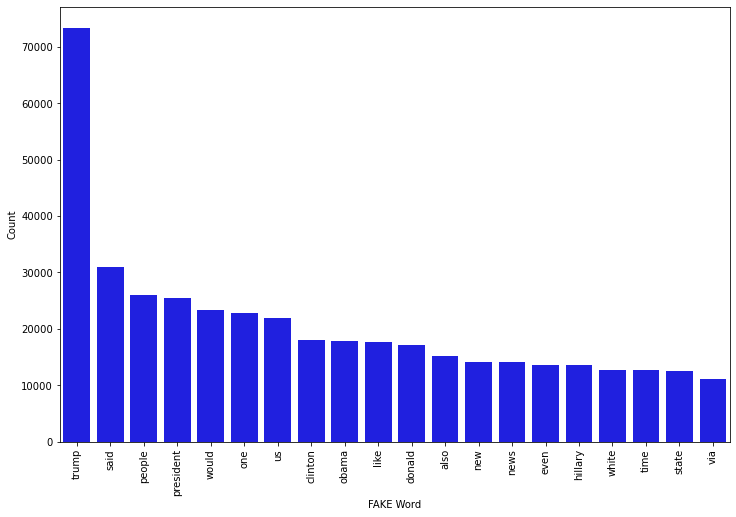

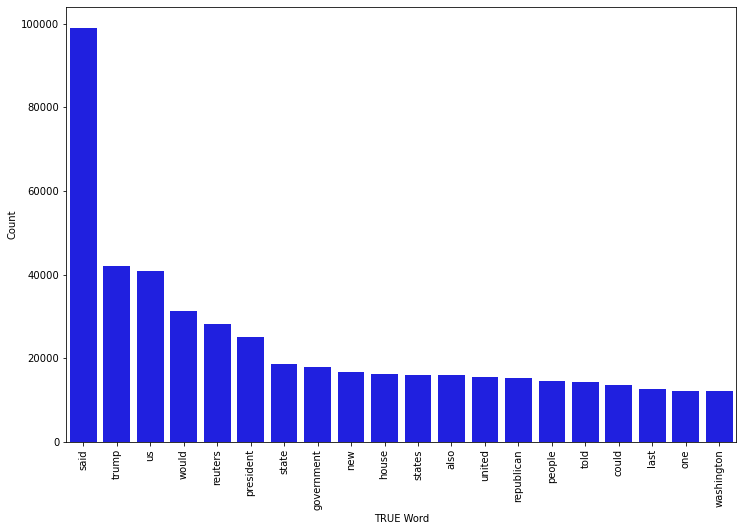

In [12]:
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity, category):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})    
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count", xlabel = (category + " Word"))
    plt.xticks(rotation='vertical')
    plt.show()
    
counter(data[data["target"] == "FAKE"], "text", 20, "FAKE")
counter(data[data["target"] == "TRUE"], "text", 20, "TRUE")

## Data Modelling

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [27]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC(max_iter=100, C=1.0))])
# Fitting the model
model = pipe.fit(X_train, y_train)
# Accuracy
prediction = model.predict(X_test)

print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.6%


In [23]:
plt.scatter(X_test, y_test, cmap='winter')
plt.show()

KeyboardInterrupt: 

In [ ]:
clf = LinearSVC(max_iter=100, C=1.0)
clf.fit(X_train, y_train)

y_pred_SVM = clf.predict(X_test)
print(cross_val_score(clf, X_text, data['target'], cv=3))
print(accuracy_score(y_pred_SVM, y_test))

scores['LinearSVC'] = accuracy_score(y_pred_SVM, y_test)

In [ ]:
from sklearn.svm import SVC
#classifier = SVC(kernel = 'rbf', random_state = 0)
#classifier.fit(X_train, y_train)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SVC(kernel = 'poly', degree=2, random_state = 0))])
# Fitting the model
model = pipe.fit(X_train, y_train)
# Accuracy
prediction = model.predict(X_test)

print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction)*100,2)))

In [ ]:
#rbf - accuracy: 52.03%
